## Seizure Diary Notebook
 Import Modules

In [1]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import datetime
import numpy as np
import warnings

 Parse Seizure Diary File and plot data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
import ipywidgets as widgets

def multi(a, b, c, d, f):
    
    # Read the data
    df = pd.read_csv('Pruned_When-Did-I.csv', index_col=2, parse_dates=True)
    df = df.loc[df['Note'] != "NHNN VT"]  # Exclude certain rows

    # Identify occurrences of 'drug changes'
    specific_action_df = df[df['Action'] == 'Change Cenobamate']
    specific_action_df1 = df[df['Action'] == 'Change Vimpat dose']
    specific_action_df2 = df[df['Action'] == 'Reduce my lamotrogine last']
    specific_action_df3 = df[df['Action'] == 'Reduce Clobazam']
    
    # Identify occurrences of seizure types
    types = list(b)
    df = df[df['Action'].isin(types)]

    # Convert the datetime column to a pandas datetime object
    df['datetime'] = df.index
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek

    # Filter by date range
    startdate = pd.to_datetime(a)
    enddate = pd.to_datetime(c)
    df = df[(df['datetime'] >= startdate) & (df['datetime'] < enddate)]

    # Create a complete range of periods
    if d == 'Weekly':
        period_freq = 'W'
        label_format = '%b %Y'  # Month Year format
    elif d=='Monthly':
        period_freq = 'M'
        label_format = '%b %Y'
    elif d=='Daily':
        period_freq = 'D'
        label_format = '%b %Y'

    all_periods = pd.period_range(start=startdate, end=enddate, freq=period_freq)

    # Group the data by period
    df['period'] = df['datetime'].dt.to_period(freq=period_freq)
    grouped = df.groupby('period').apply(lambda x: np.histogram(x['hour'], bins=range(25))[0])
    grouped_df = pd.DataFrame(grouped.tolist(), index=grouped.index)

    # Merge with the complete periods
    complete_grouped_df = grouped_df.reindex(all_periods, fill_value=0)

    # Visualization
    fig = plt.figure(figsize=(12, 9))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 4], width_ratios=[20, 1])

    # Axes for the histogram
    ax0 = plt.subplot(gs[0, 0])

    # Axes for the heatmap
    ax1 = plt.subplot(gs[1, 0])

    # Axes for the colorbar (aligned with the heatmap)
    ax2 = plt.subplot(gs[1, 1])

    # Plotting Histogram for Counts
    ax0.bar(complete_grouped_df.index.astype(str), complete_grouped_df.sum(axis=1), color='blue')
    ax0.set_title(f'{d} Seizure Count')
    ax0.set_xticklabels([])  # Remove x-tick labels
    ax0.set_ylabel('Count')
    ax0.set_xlim([-0.5, len(complete_grouped_df.index) - 0.5])  # Align x-axis with heatmap

    # Plot Heatmap

    im = ax1.imshow(complete_grouped_df.T, aspect='auto', cmap='viridis',vmin=-0, vmax=3)  # Transpose the DataFrame
    ax1.set_title(f'{d} Seizure Counts by Hour of Day')
    ax1.set_xlabel('Period')


    # Only label the first week of each month
    if d == 'Weekly':
        labels = [''] * len(all_periods)
        previous_month = None
        for i, period in enumerate(all_periods):
            if period.month != previous_month:
                labels[i] = period.strftime('%b %Y')
                previous_month = period.month
    else:  # If it's monthly, label each month
        labels = [period.strftime('%b %Y') for period in all_periods]

    ax1.set_xticks(np.arange(len(all_periods)))
    ax1.set_xticklabels(labels, rotation=90)
    ax1.set_ylabel('Hour of Day')
    index=[]

    # add datetime to spec actions
    specific_action_df['datetime'] = specific_action_df.index
    specific_action_df1['datetime'] = specific_action_df1.index
    specific_action_df2['datetime'] = specific_action_df2.index
    specific_action_df3['datetime'] = specific_action_df3.index
    
    # Add a new column for period index
    def get_period_index(date):
        period = date.to_period(freq=period_freq)
        if period in all_periods:
            return np.where(all_periods == period)[0][0]
        else:
            return None

    specific_action_df['period_index'] = specific_action_df['datetime'].apply(get_period_index)
    specific_action_df1['period_index'] = specific_action_df1['datetime'].apply(get_period_index)
    specific_action_df2['period_index'] = specific_action_df2['datetime'].apply(get_period_index)
    specific_action_df3['period_index'] = specific_action_df3['datetime'].apply(get_period_index)
    
    if f == 'Yes':
        ax1.text(1, 10, 'CNB', ha='center', va='center', color='white',fontsize=16)
        for i in range(1,len(specific_action_df)):
            if specific_action_df['period_index'][i] is not None and np.isfinite(specific_action_df['period_index'][i]):
        # Annotate specific actions on the heatmap
                note=specific_action_df['Note'][i]
                ax1.text(specific_action_df['period_index'][i], 11, note, ha='center', va='center', color='white',fontsize=14)

        #ax1.text(2, 13, 'LAC 600', ha='center', va='center', color='red',fontsize=16)
        for i in range(1,len(specific_action_df1)):
            if specific_action_df1['period_index'][i] is not None and np.isfinite(specific_action_df1['period_index'][i]):
        # Annotate specific actions on the heatmap
                note=specific_action_df1['Note'][i]
                ax1.text(specific_action_df1['period_index'][i], 13, note, ha='center', va='center', color='red',fontsize=14)
        
   # Add colorbar
    plt.colorbar(im, cax=ax2)

    plt.tight_layout()
    plt.show()


    return specific_action_df,df,all_periods

    

# Example usage with widgets
a = widgets.DatePicker(description='Start Date', value=datetime.date.today() - pd.Timedelta(days=365))
b = widgets.SelectMultiple(
    options=['Standard nighttime Seizure', 'Seizure from Wakefulness', 'Have continuous focal SE'],
    value=['Standard nighttime Seizure', 'Seizure from Wakefulness'],
    description='Seizures to Display',
    disabled=False
)
c = widgets.DatePicker(description='End Date', value=datetime.date.today()+ datetime.timedelta(days=1))
d = widgets.RadioButtons(
    options=['Weekly', 'Monthly','Daily'],
    description='Binning:',
    disabled=False
)
f = widgets.RadioButtons(
    options=['Yes', 'No'],
    description='Show Meds:',
    disabled=False
)
# Suppress warnings for finite values
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
        
e = widgets.interactive(multi, a=a, b=b, c=c, d=d,f=f)
display(e)


interactive(children=(DatePicker(value=datetime.date(2023, 7, 1), description='Start Date'), SelectMultiple(de…

In [3]:
e.result[1].count()

Icon           96
Action         96
Time Zone      96
City Name       0
Address         0
Coordinates     0
Note            1
datetime       96
hour           96
dayofweek      96
period         96
dtype: int64

Import Apple Watch Health Data

In [3]:
import xml.etree.ElementTree as ET
# create element tree object
tree = ET.parse('apple_health_export/export.xml') 
# for every health record, extract the attributes
root = tree.getroot()

workout_list = [x.attrib for x in root.iter('Workout')]

# create DataFrame
workout_data = pd.DataFrame(workout_list)
workout_data['workoutActivityType'] = workout_data['workoutActivityType'].str.replace('HKWorkoutActivityType', '')
workout_data = workout_data.rename({"workoutActivityType": "Type"}, axis=1)

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    workout_data[col] = pd.to_datetime(workout_data[col])

# convert string to numeric   
workout_data['duration'] = pd.to_numeric(workout_data['duration'])
workout_data_reduced=workout_data.loc[workout_data['startDate']>a.value.isoformat()]
workout_data_reduced=workout_data_reduced.loc[workout_data_reduced['startDate']<c.value.isoformat()]

# record_list = [x.attrib for x in root.iter('Record')]
# record_data = pd.DataFrame(record_list)
# # proper type to dates
# for col in ['creationDate', 'startDate', 'endDate']:
#     record_data[col] = pd.to_datetime(record_data[col])

# # value is numeric, NaN if fails
# record_data['value'] = pd.to_numeric(record_data['value'], errors='coerce')

# # some records do not measure anything, just count occurences
# # filling with 1.0 (= one time) makes it easier to aggregate
# record_data['value'] = record_data['value'].fillna(1.0)

# # shorter observation names
# record_data['type'] = record_data['type'].str.replace('HKQuantityTypeIdentifier', '')
# record_data['type'] = record_data['type'].str.replace('HKCategoryTypeIdentifier', '')
workout_list = [x.attrib for x in root.iter('Workout')]

# create DataFrame
workout_data = pd.DataFrame(workout_list)
workout_data['workoutActivityType'] = workout_data['workoutActivityType'].str.replace('HKWorkoutActivityType', '')
workout_data = workout_data.rename({"workoutActivityType": "Type"}, axis=1)

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    workout_data[col] = pd.to_datetime(workout_data[col])

# convert string to numeric   
workout_data['duration'] = pd.to_numeric(workout_data['duration'])
# workout_data['totalDistance'] = pd.to_numeric(workout_data['totalDistance'])
workout_data_reduced=workout_data.loc[workout_data['startDate']>a.value.isoformat()]
workout_data_reduced=workout_data_reduced.loc[workout_data_reduced['startDate']<c.value.isoformat()]


In [3]:
ax1=sns.displot(data=e.result, 
            x='hour',
            rug=True,
            kind="hist",
            kde=True,
           bins=48)
ax1.set_ylabels(label='Seizure count')

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

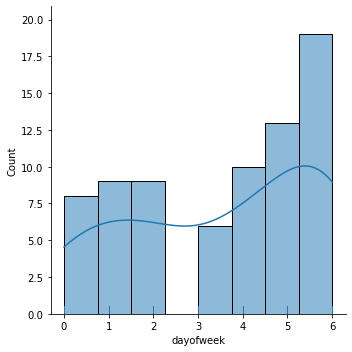

In [5]:
ax2=sns.displot(data=e.result, 
            x='dayofweek',
            rug=True,
            kind="hist",
           kde=True)